# Import the necessary packages
## Install the gradcam packages using: 'pip install pytorch-gradcam'
The code repository is available at https://github.com/vickyliin/gradcam_plus_plus-pytorch

In [1]:
pip install pytorch-gradcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5246 sha256=fee8ed13f7c2f3b16131e03ca86759c4dd77b0f828cba4f55ac1297ee80c7053
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [2]:
import os
import cv2
import PIL
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Download the imagenet_class_index.json file from the following link https://gist.github.com/AyushSomani001/17346595333e73fe78208756f11fcebb
## Load it

In [3]:
import json
imagenet_class_index = json.load(open('ImageNet_class_index.json'))

# Load the some example images of your choice

In [10]:
# Load the dog, cat, rooster and lizard images
dog = cv2.imread('/content/dog.png')
cat = cv2.imread('/content/cat.png')
rooster = cv2.imread('/content/rooster.png')
lizard = cv2.imread('/content/lizard.png')

## Resize them to 224x224

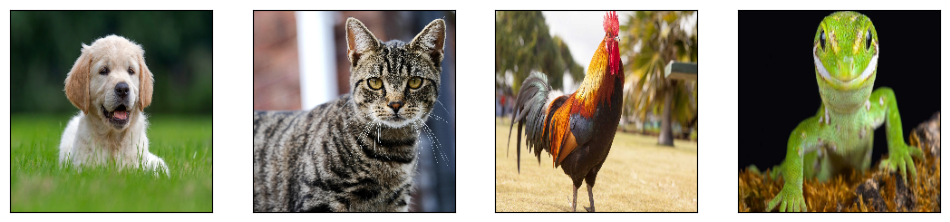

In [11]:
# Resize all the images to 224x224
dog = cv2.resize(dog, (224, 224))
cat = cv2.resize(cat, (224, 224))
rooster = cv2.resize(rooster, (224, 224))
lizard = cv2.resize(lizard, (224, 224))

fig = plt.figure(figsize=(12, 12))
for i, img in enumerate([dog, cat, rooster, lizard]):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(img[:, :, ::-1])

## Download a few test models of your choice

In [12]:
alexnet = models.alexnet(pretrained=True)
vgg = models.vgg16(pretrained=True)
resnet = models.resnet101(pretrained=True)
densenet = models.densenet161(pretrained=True)
squeezenet = models.squeezenet1_1(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 92.0MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be remove

In [13]:
configs = [
    dict(model_type='alexnet', arch=alexnet, layer_name='features_11'),
    dict(model_type='vgg', arch=vgg, layer_name='features_29'),
    dict(model_type='resnet', arch=resnet, layer_name='layer4'),
    dict(model_type='densenet', arch=densenet, layer_name='features_norm5'),
    dict(model_type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation')
]

## Get the results for gradCAM and gradCAM++

In [14]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

## Test on any sample image of your choice

In [15]:
dog_tensor = transforms.Compose([
                                transforms.ToTensor()])(dog).to(device)
dog_normed_torch = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])(dog_tensor)[None]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


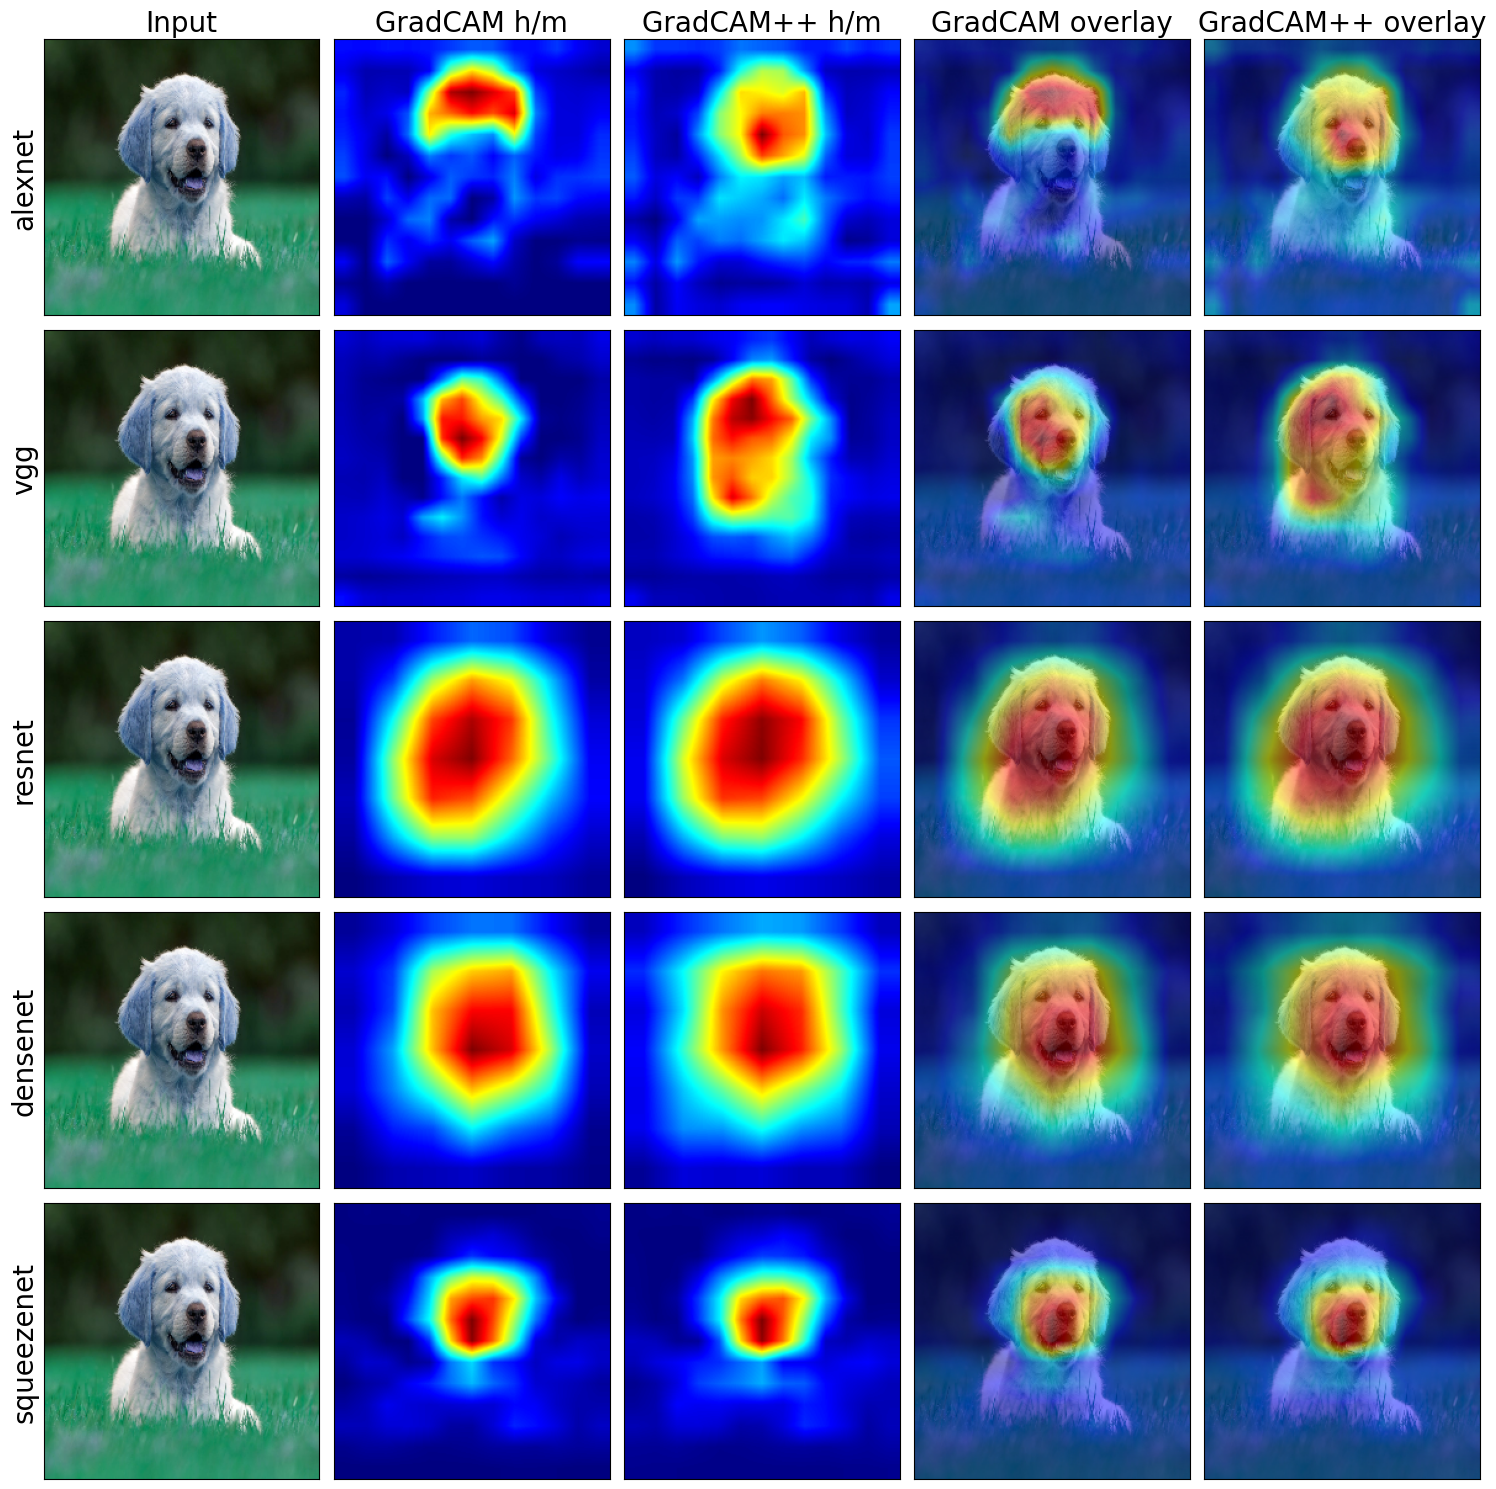

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

# Assuming you have the `images` tensor defined
images = np.zeros((5, 5, 3, 224, 224))

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

i = 0

# Iterate over each subplot and display the corresponding image
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(dog_normed_torch)
    heatmap, result = visualize_cam(mask, dog_tensor)

    mask_pp, _ = gradcam_pp(dog_normed_torch)
    heatmap_pp, result_pp = visualize_cam(mask_pp, dog_tensor)

    images[i, 0, :, :, :] = dog_tensor.cpu().numpy().reshape(3, 224, 224)
    images[i, 1, :, :, :] = heatmap.cpu().numpy().reshape(3, 224, 224)
    images[i, 2, :, :, :] = heatmap_pp.cpu().numpy().reshape(3, 224, 224)
    images[i, 3, :, :, :] = result.cpu().numpy().reshape(3, 224, 224)
    images[i, 4, :, :, :] = result_pp.cpu().numpy().reshape(3, 224, 224)

    for j in range(5):
        ax = axes[i, j]
        ax_x = axes[i, 0]
        image = images[i, j]  # Select individual image from the tensor

        # Reshape or transpose the image tensor if needed
        image = np.transpose(image, (1, 2, 0))  # Assuming the shape is (3, 224, 224)

        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])

    i += 1

# Set the x labels for each column as the name of the technique used
for j in range(5):
    axes[0, j].set_title(['Input', 'GradCAM h/m', 'GradCAM++ h/m', 'GradCAM overlay', 'GradCAM++ overlay'][j], fontsize=20)

# Set the y labels for each row as the name of the model
for i in range(5):
    axes[i, 0].set_ylabel(configs[i]['model_type'], fontsize=20)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


## Print the predicted class with maximum probability. Here we showcase the resnet model. You can use any model of your choice

In [17]:
# Print the predicted class for the dog image wih the highest probability with reference to the imagenet class index
# Predict the class for the dog image
class_idx = torch.argmax(resnet(dog_normed_torch))
predicted_class = imagenet_class_index[str(class_idx.item())]
print(f'Predicted Class = {predicted_class}')

Predicted Class = Great Pyrenees


# **Task**: Repeat the same steps for another image of your choice. You can use any model of your choice, say VGG model.

In [ ]:
# Assuming you define the `images` tensor here


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid


# Assuming you have the `images` tensor defined

# Create a 5x5 grid of subplots


# Iterate over each subplot and display the corresponding image



# Set the x labels for each column as the name of the technique used


# Set the y labels for each row as the name of the model



# Adjust spacing between subplots


# Display the plot

In [ ]:
# Print the predicted class for the selected image wih the highest probability with reference to the imagenet class index


# Predict the class for the selected image

# Let us try to create an image using cropped versions of other images and see what the results are

In [ ]:
# Create a 224x224 image with cropped parts of four single object image, say we use the above example of dog, cat, rooster, and lizard in each of its four corners.

In [ ]:
# Convert the image to a tensor and normalize it with mean and standard deviation




# ....